S&P 500 Forecasting Using SARIMAX (2026 Outlook)

This project applies a seasonal ARIMA (SARIMAX) time-series model to monthly S&P 500 index data to generate a probabilistic forecast for 2026. Historical data through 2025 is used to capture long-term trends, seasonal dynamics, and persistence commonly observed in equity markets.

The analysis emphasizestationarity testing, model diagnostics, and confidence intervals, providing a risk-aware outlook rather than point predictions alone. The goal is to demonstrate how econometric time-series methods can be used for macro-level market analysis and uncertainty assessment, not the trading signals.

In [33]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import statsmodels.api as sm
from arch.unitroot import KPSS, ADF
from statsmodels.stats.outliers_influence import summary_table

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

In [36]:
sp500 = yf.download(
    "^GSPC",
    start="2015-01-01",
    end="2025-12-31",
    interval="1d",
    auto_adjust=True,
    progress=False
)

df = sp500.resample("M").last()

In [37]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-01-31,1994.989990,2023.319946,1993.380005,2019.349976,4568650000
2015-02-28,2104.500000,2112.739990,2103.750000,2110.879883,3547380000
2015-03-31,2067.889893,2084.050049,2067.040039,2084.050049,3376550000
2015-04-30,2085.510010,2105.520020,2077.590088,2105.520020,4509680000
2015-05-31,2107.389893,2120.659912,2104.889893,2120.659912,3927390000


In [38]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2025-08-31,6460.259766,6491.759766,6444.569824,6489.279785,4234840000
2025-09-30,6688.459961,6691.250000,6641.000000,6656.189941,6057210000
2025-10-31,6840.200195,6879.169922,6814.259766,6879.169922,6398280000
2025-11-30,6849.089844,6850.859863,6819.750000,6822.520020,2558540000
2025-12-31,6896.240234,6913.250000,6893.470215,6900.439941,3309930000


In [39]:
df_month = df.resample('M').last()

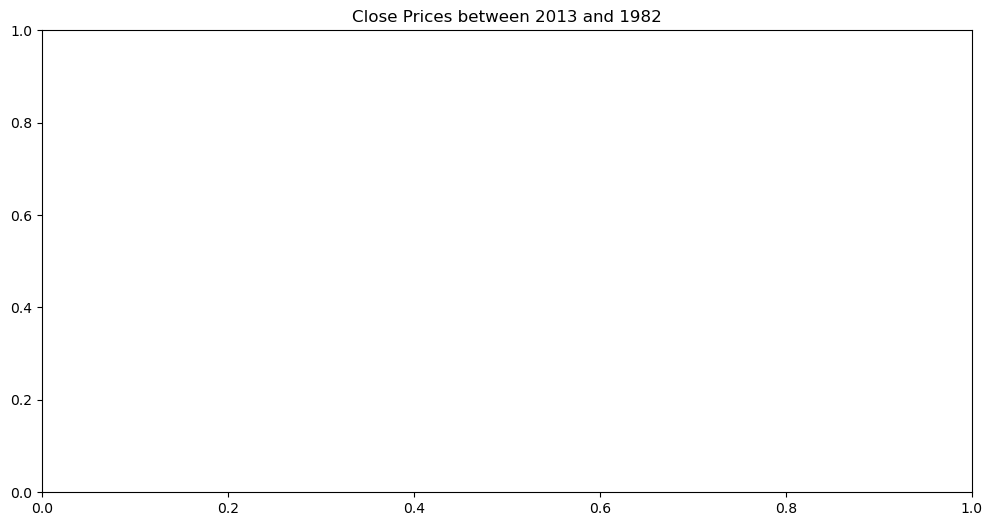

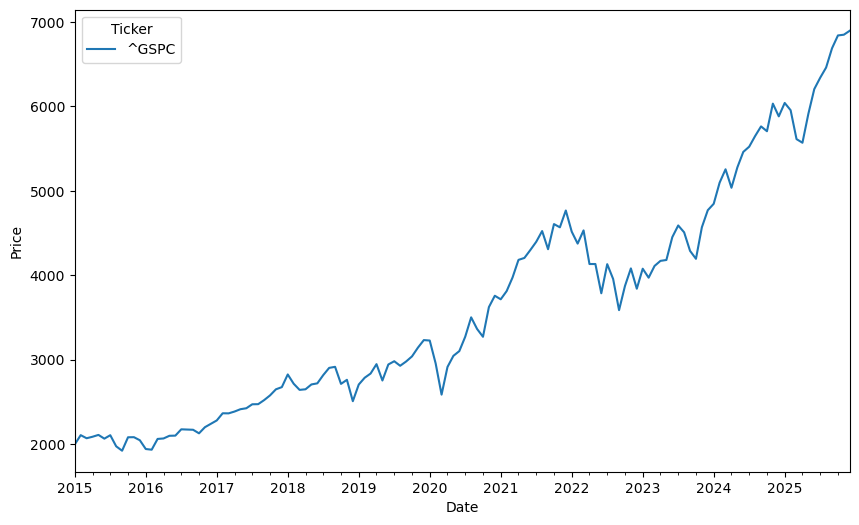

In [40]:
plt.figure(figsize=(12, 6))
plt.title(f'Close Prices between {2015-1-1} and {2025-12-31}')
df_month['Close'].plot()
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

In [41]:
df_month.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-01-31,1994.989990,2023.319946,1993.380005,2019.349976,4568650000
2015-02-28,2104.500000,2112.739990,2103.750000,2110.879883,3547380000
2015-03-31,2067.889893,2084.050049,2067.040039,2084.050049,3376550000
2015-04-30,2085.510010,2105.520020,2077.590088,2105.520020,4509680000
2015-05-31,2107.389893,2120.659912,2104.889893,2120.659912,3927390000


In [42]:
df_month.index.freq

<MonthEnd>

In [43]:
df_month=df_month.rename(columns={"Close": "Price"}, inplace=False)
df_month
cols_to_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
df2 = df_month.drop(columns=cols_to_drop, errors='ignore')

Dickey-Fuller test : p=0.994129


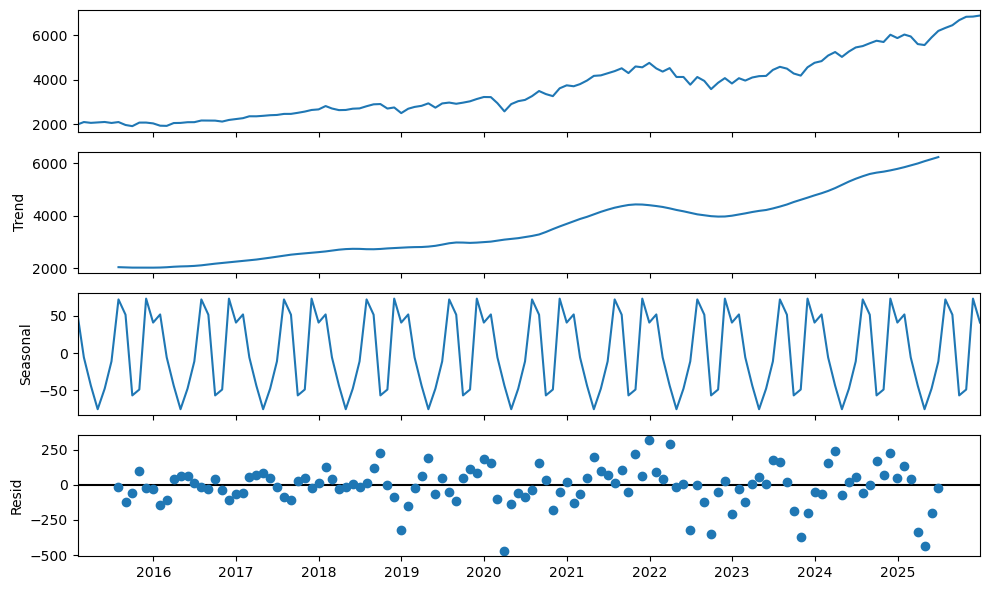

In [44]:
plt.rc ("figure", figsize = (10,6))
sm.tsa.seasonal_decompose(df2.Price).plot()
print("Dickey-Fuller test : p=%f"% sm.tsa.stattools.adfuller(df2.Price)[1])
plt.show()

In [45]:
ADF(df2.Price)

Test Statistic,0.987
P-value,0.994
Lags,0


Dickey-Fuller test: p=0.000000


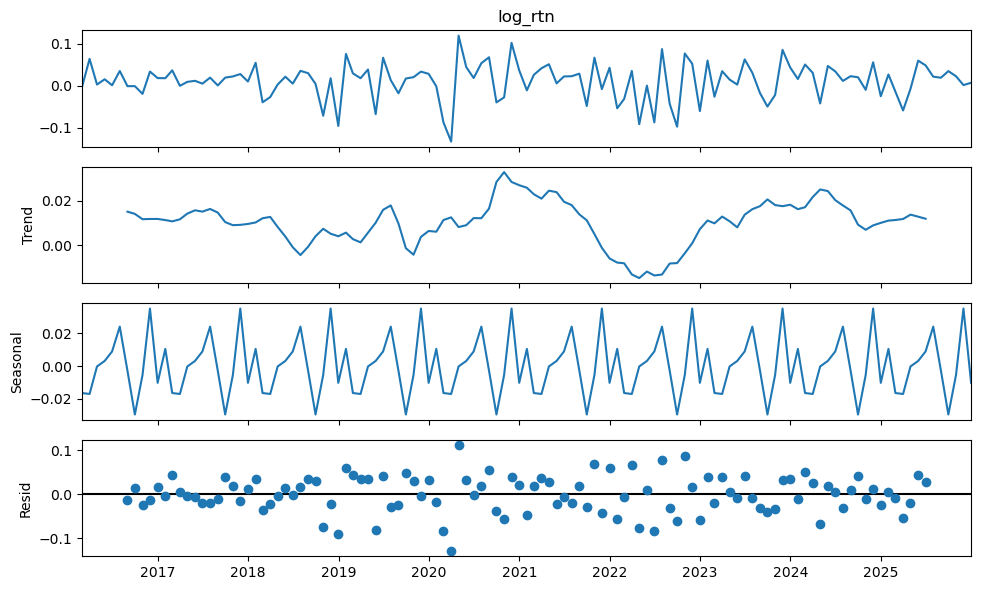

In [46]:
df2 ['log_rtn'] = np.log(df2.Price/df2.Price.shift(1))
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df2.log_rtn[13:])[1])

# STL- decomposition
sm.tsa.seasonal_decompose(df2.log_rtn[13:]).plot()

plt.show()

In [47]:
df2 = df2.dropna(axis = 0)
df2.isnull().sum()

Price    Ticker
Price    ^GSPC     0
log_rtn            0
dtype: int64

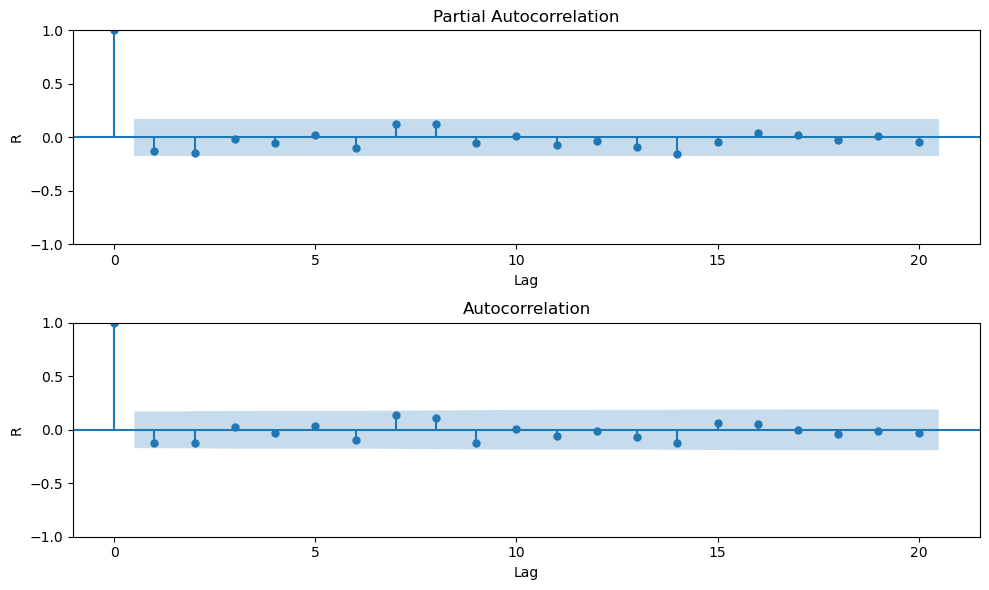

In [48]:
fig, axs = plt.subplots(2)
sm.graphics.tsa.plot_pacf(df2.log_rtn, lags=20, ax=axs[0])
axs[0].set_ylabel('R')
axs[0].set_xlabel('Lag')
sm.graphics.tsa.plot_acf(df2.log_rtn, lags=20, ax=axs[1]);
axs[1].set_ylabel('R')
axs[1].set_xlabel('Lag')
fig.tight_layout()

In [49]:
from itertools import product

Qs = range(0, 3)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df2.Price, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    
    bic = model.bic
    best_bic = bic   
    if bic < best_bic:
        best_model = model
        best_bic = bic
        best_param = param
    results.append([param, model.bic])

In [50]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'bic']
print(result_table.sort_values(by = 'bic', ascending=True).head())
bic_model=sm.tsa.statespace.SARIMAX(df2.Price, order=(1,1,1), 
                                        seasonal_order=(1,1,1, 12)).fit(disp=-1)
print(bic_model.summary())

      parameters          bic
1   (0, 0, 0, 1)  1567.755446
10  (0, 1, 0, 1)  1571.028040
28  (1, 0, 0, 1)  1571.117858
2   (0, 0, 0, 2)  1572.461904
4   (0, 0, 1, 1)  1572.462515
                                     SARIMAX Results                                      
Dep. Variable:                              ^GSPC   No. Observations:                  131
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -778.982
Date:                            Sat, 03 Jan 2026   AIC                           1567.963
Time:                                    02:29:20   BIC                           1581.817
Sample:                                02-28-2015   HQIC                          1573.588
                                     - 12-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

Dickey–Fuller test:: p=0.000000


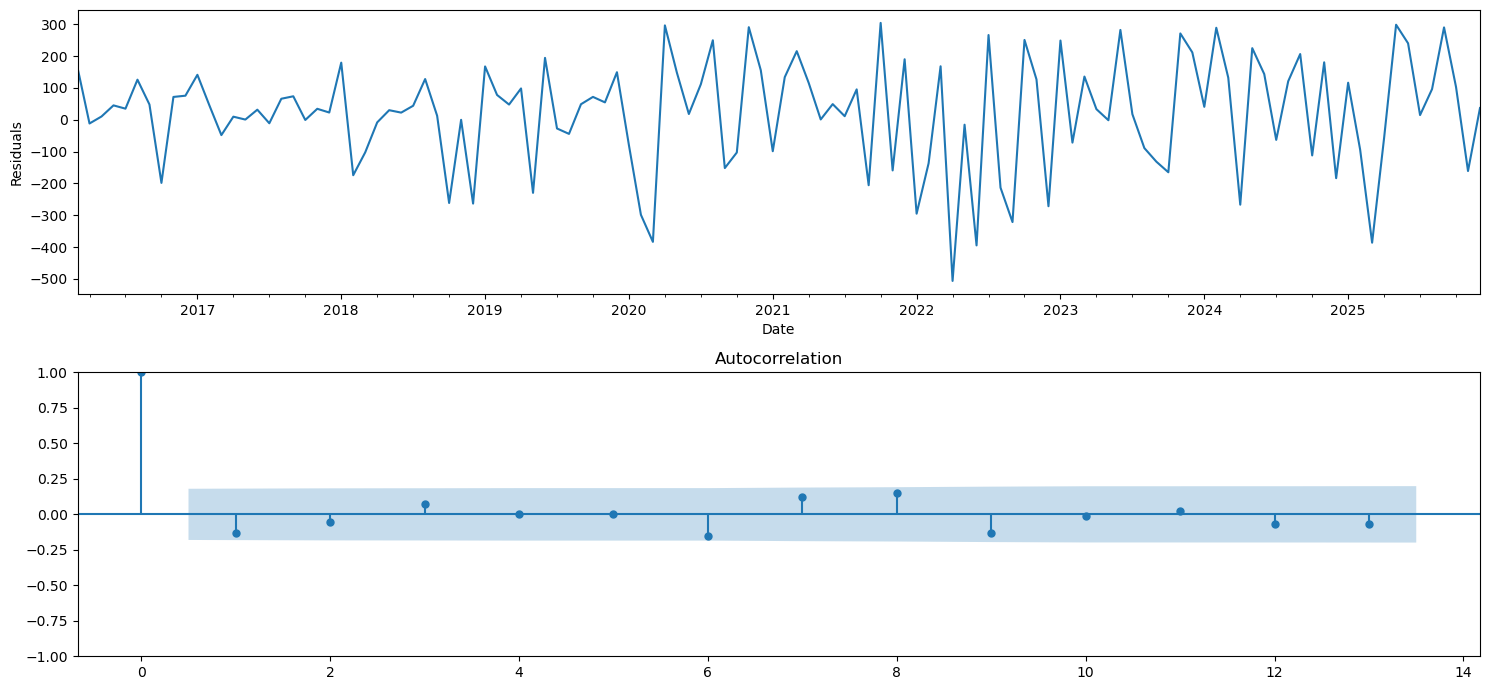

In [51]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
bic_model.resid[13:].plot()
plt.ylabel('Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(bic_model.resid[13:].values.squeeze(), lags=13, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(bic_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [52]:
date_list = [datetime(2026, 5, 31), 
             datetime(2026, 6, 30), datetime(2026, 7, 31), datetime(2026, 8, 31),
             datetime(2026, 9, 30),datetime(2026, 10, 31), datetime(2026, 11, 30),datetime(2026, 12, 31)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = bic_model.predict(start=20, end=144)

<Figure size 1500x700 with 0 Axes>

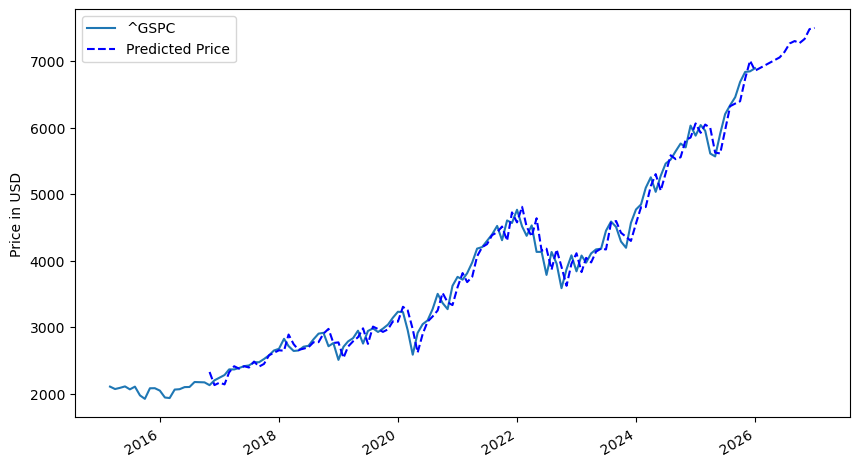

In [53]:
plt.figure(figsize=(15,7))
df2.Price.plot()
df2.forecast.plot(color='b', ls='--', label='Predicted Price')
plt.legend()
#lt.title(symbol + ' Price Monthly')
plt.ylabel('Price in USD')
plt.show()

In [54]:
predictions_int = bic_model.get_forecast(steps=24)
predictions_int.predicted_mean

2026-01-31    6957.100586
2026-02-28    6952.543286
2026-03-31    6955.694870
2026-04-30    6976.886254
2026-05-31    7059.115770
2026-06-30    7142.341008
2026-07-31    7268.563590
2026-08-31    7305.298866
2026-09-30    7274.540793
2026-10-31    7336.731870
2026-11-30    7484.331057
2026-12-31    7502.252044
2027-01-31    7561.010474
2027-02-28    7558.005520
2027-03-31    7568.090266
2027-04-30    7590.478108
2027-05-31    7667.300983
2027-06-30    7746.144910
2027-07-31    7872.094504
2027-08-31    7907.011491
2027-09-30    7870.876462
2027-10-31    7931.139190
2027-11-30    8081.456592
2027-12-31    8098.677276
Freq: ME, Name: predicted_mean, dtype: float64

In [55]:
predictions_int.conf_int()

,lower ^GSPC,upper ^GSPC
2026-01-31,6631.104229,7283.096943
2026-02-28,6489.142424,7415.944148
2026-03-31,6385.804506,7525.585235
2026-04-30,6315.708993,7638.063515
2026-05-31,6316.232423,7801.999117
2026-06-30,6324.459753,7960.222264
2026-07-31,6380.694797,8156.432384
2026-08-31,6351.353196,8259.244536
2026-09-30,6257.669967,8291.411619
2026-10-31,6259.538833,8413.924907


In [56]:
str

str

In [57]:
print("df2 duplicates:", df2.index.duplicated().sum())
print("pred_mean duplicates:", predictions_int.predicted_mean.index.duplicated().sum())
print("conf_int duplicates:", predictions_int.conf_int().index.duplicated().sum())


df2 duplicates: 0
pred_mean duplicates: 0
conf_int duplicates: 0


In [58]:
df2 = df2[~df2.index.duplicated(keep="last")].sort_index()
df2.index = pd.to_datetime(df2.index)

In [59]:
pred_mean = predictions_int.predicted_mean.copy()
pred_ci = predictions_int.conf_int().copy()

pred_mean.name = "Forecast"
pred_ci.columns = ["Lower CI", "Upper CI"]


In [60]:
forecast_df = pd.concat([pred_mean, pred_ci], axis=1)
forecast_df.head()

,Forecast,Lower CI,Upper CI
2026-01-31,6957.100586,6631.104229,7283.096943
2026-02-28,6952.543286,6489.142424,7415.944148
2026-03-31,6955.694870,6385.804506,7525.585235
2026-04-30,6976.886254,6315.708993,7638.063515
2026-05-31,7059.115770,6316.232423,7801.999117


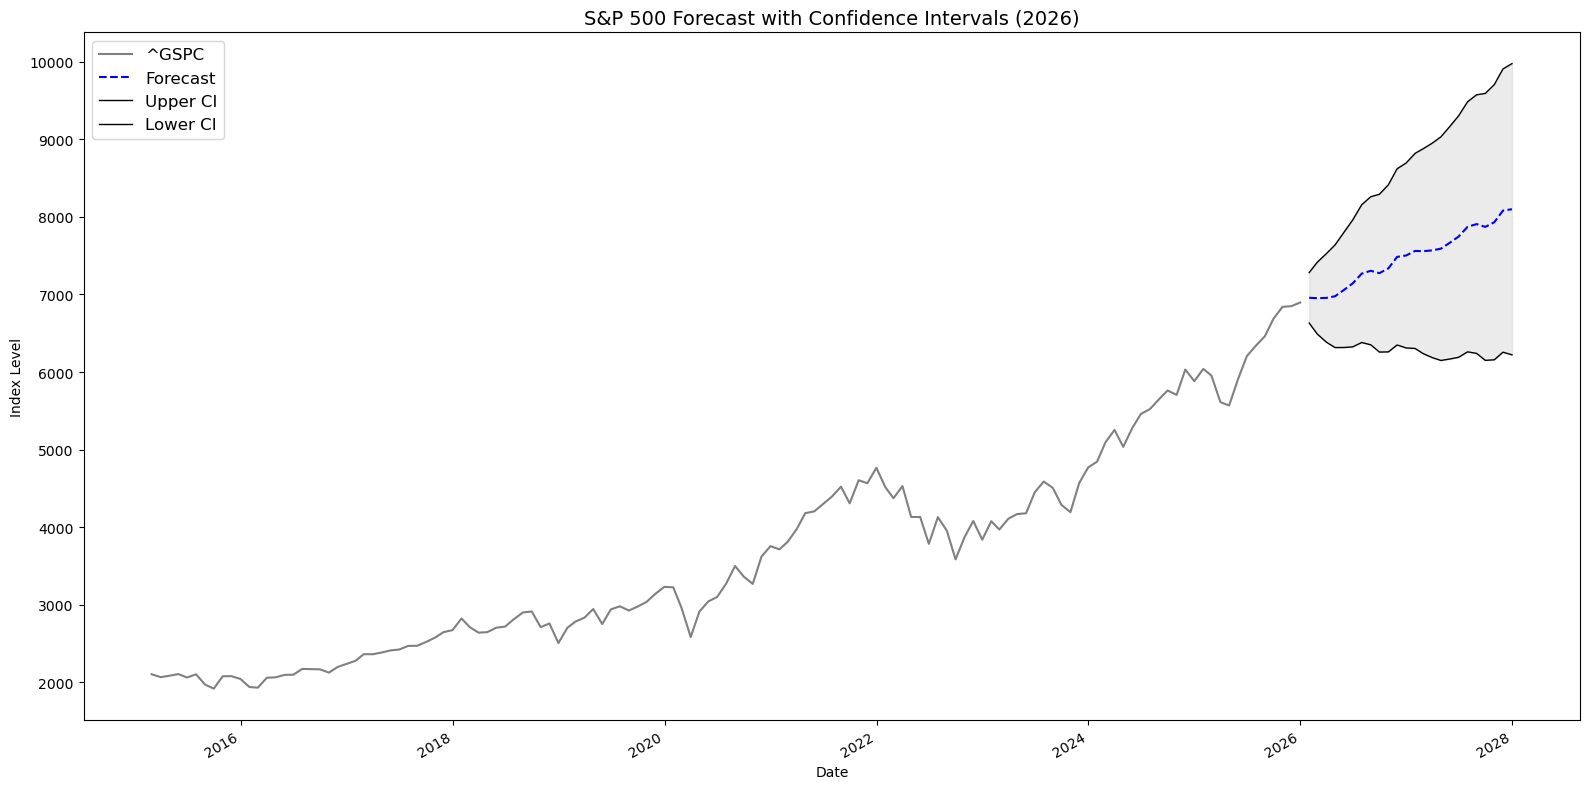

In [61]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)

# Actuals
df2['Price'].plot(ax=ax1, color='grey', label='Actual')

# Forecast
pred_mean.plot(ax=ax1, color='blue', linestyle='--', label='Forecast')

# Confidence intervals
pred_ci['Upper CI'].plot(ax=ax1, color='black', linewidth=1, label='Upper CI')
pred_ci['Lower CI'].plot(ax=ax1, color='black', linewidth=1, label='Lower CI')

# Shaded CI band (forecast period only)
ax1.fill_between(
    pred_ci.index,
    pred_ci['Lower CI'],
    pred_ci['Upper CI'],
    color='silver',
    alpha=0.3
)

ax1.legend(loc='upper left', fontsize=12)
ax1.set_title('S&P 500 Forecast with Confidence Intervals (2026)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Index Level')

plt.tight_layout()
plt.savefig("sp500_2026_forecast_linkedin.png", dpi=300, bbox_inches="tight")
plt.show()